# Plot Comupute Statistics for OSG Job

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import multiprocessing
import h5py
from datetime import datetime, timedelta

In [2]:
import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [12, 6]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [3]:
def get_field_MP(inputs):
    """
    Function for MultiProcessing.
    Return the value from a key in the HDF5 file array
    """
    FILE, STAT = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT].value
    except:
        #print "missing:", FILE
        return np.nan

In [4]:
var = 'DPT:2 m'
#var = 'WIND:10 m'

variable = var.replace(':', '_').replace(' ', '_')

DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/TMP_2_m_TEST/'

In [5]:
months = range(1,13)
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
hours = range(24)

# Dates (with leap year)
HOURS = 366*24
DATES = np.array([datetime(2016, 1, 1) + timedelta(hours = h) for h in range(HOURS)])

In [6]:
# Get compute statistics from every file
      
# Multiprocessing :)
cores = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'cores'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

count = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'count'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

timer = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'timer'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

num_proc = multiprocessing.cpu_count()
p = multiprocessing.Pool(num_proc)
cores = np.array(p.map(get_field_MP, cores))
count = np.array(p.map(get_field_MP, count))
timer = np.array(p.map(get_field_MP, timer))
p.close()

In [7]:
# Timer in seconds
Timer = []
for t in timer:
    try:
        Timer.append(int(t.split(':')[0])*86400 + int(t.split(':')[1])*60 + float(t.split(':')[2]))
    except:
        Timer.append(np.nan)

## Cores vs. DATE

(0, 60.0)

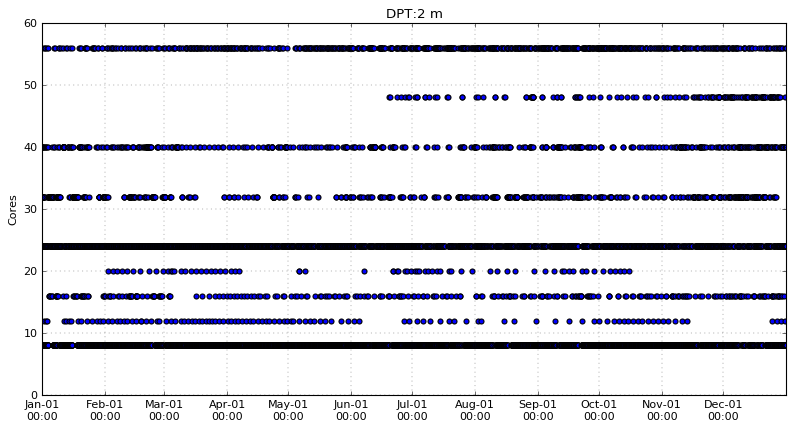

In [8]:
plt.figure(1)
plt.scatter(DATES, cores)
plt.ylabel('Cores')
plt.title(var)
formatter = DateFormatter('%b-%d\n%H:00')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.grid()
plt.xlim(DATES[0], DATES[-1])
plt.ylim(ymin=0)

## Computation Time vs Date

(0, 400.0)

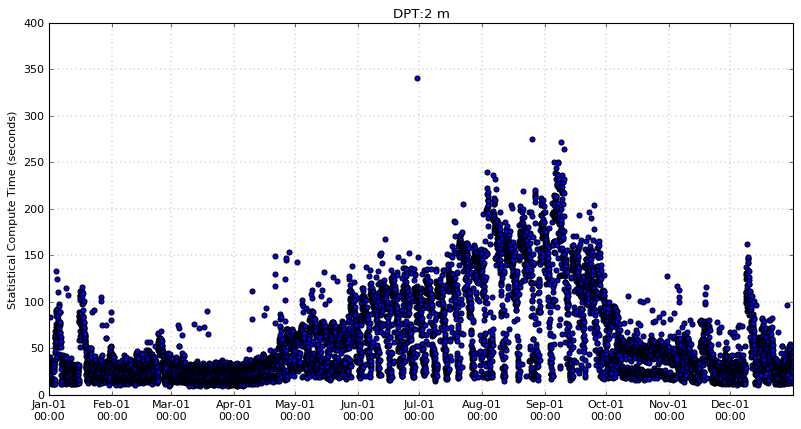

In [9]:
plt.figure(3)
plt.scatter(DATES, Timer)
plt.ylabel('Statistical Compute Time (seconds)')
plt.title(var)
formatter = DateFormatter('%b-%d\n%H:00')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.grid()
plt.xlim(DATES[0], DATES[-1])
plt.ylim(ymin=0)

## Computation Time versus Sample Count

(0, 400.0)

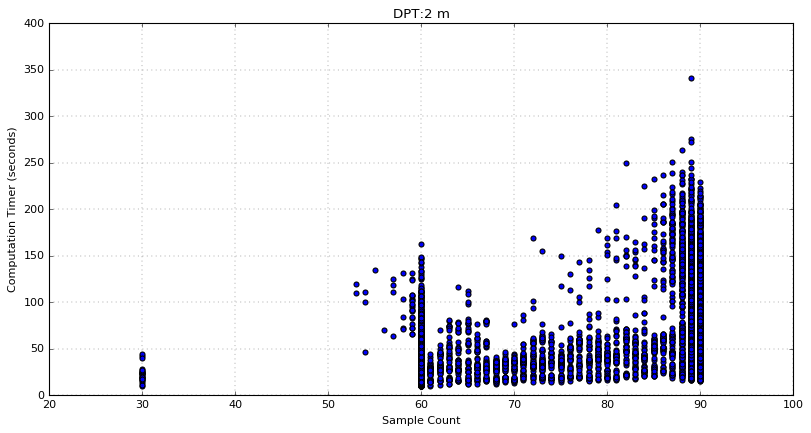

In [10]:
plt.figure(4)
plt.scatter(count, Timer)
plt.xlabel('Sample Count')
plt.ylabel('Computation Timer (seconds)')
plt.title(var)
plt.grid()
plt.ylim(ymin=0)

## Number of Samples Per File

(0, 100.0)

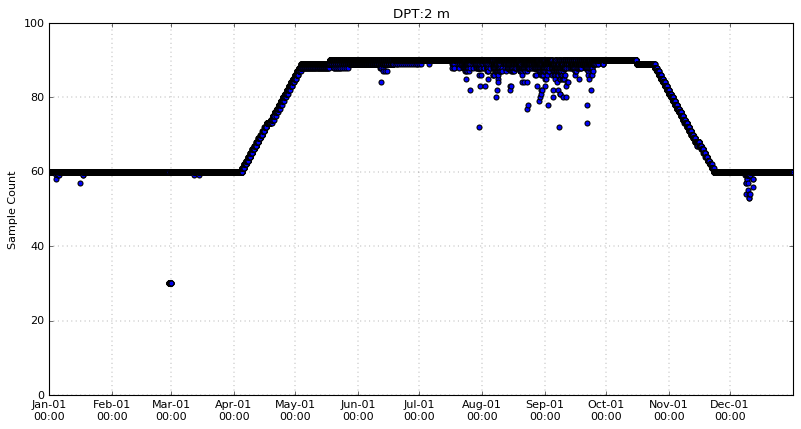

In [11]:
plt.scatter(DATES, count)
plt.ylabel('Sample Count')
plt.title(var)
formatter = DateFormatter('%b-%d\n%H:00')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.grid()
plt.xlim(DATES[0], DATES[-1])
plt.ylim(ymin=0)

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


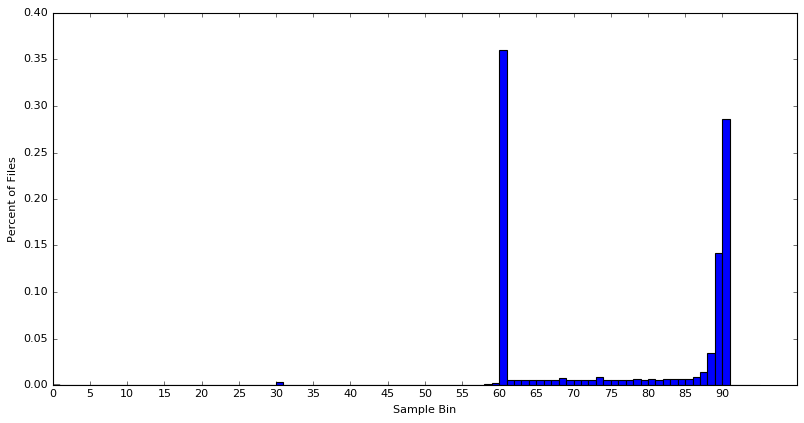

In [12]:
a = plt.hist(count, bins=95, range=[0,95], normed=True)
plt.ylabel('Percent of Files')
plt.xlabel('Sample Bin')
b = plt.xticks(range(0,95,5))

## Compuation Time and Cores

(0, 400.0)

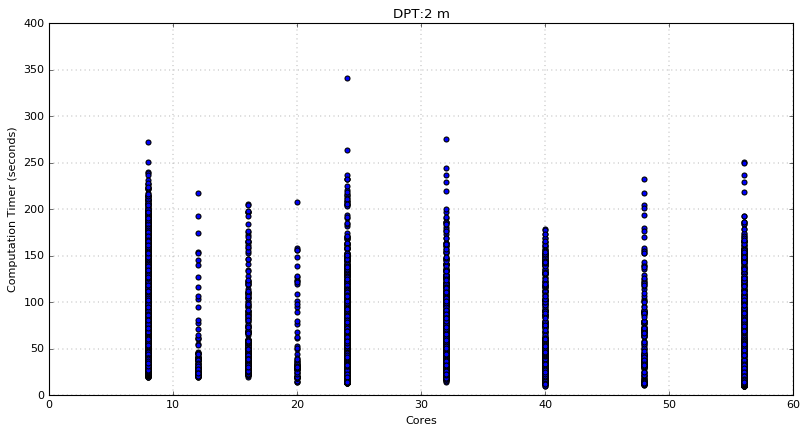

In [13]:
plt.figure(5)
plt.scatter(cores, Timer)
plt.xlabel('Cores')
plt.ylabel('Computation Timer (seconds)')
plt.title(var)
plt.grid()
plt.ylim(ymin=0)

## Missing Files

27 Missing Files


(735964.0, 736329.9583333334)

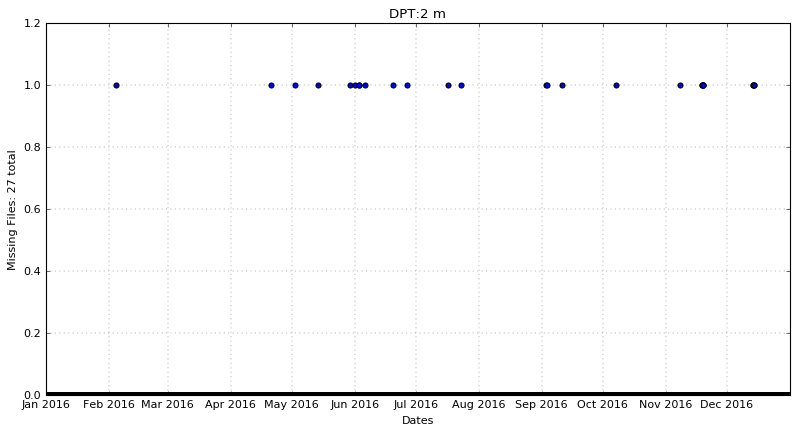

In [14]:
NANS = []
for a in cores:
    if np.isnan(a):
        NANS.append(1)
    else:
        NANS.append(0)

print "%s Missing Files" % np.sum(NANS)
        
plt.figure(6)
plt.scatter(DATES, NANS)
plt.xlabel('Dates')
plt.ylabel('Missing Files: %s total' % np.sum(NANS))
plt.title(var)
plt.grid()
plt.ylim(ymin=0)
plt.xlim([DATES[0],DATES[-1]])

## Number of Sample vs Number of Cores

(0, 100.0)

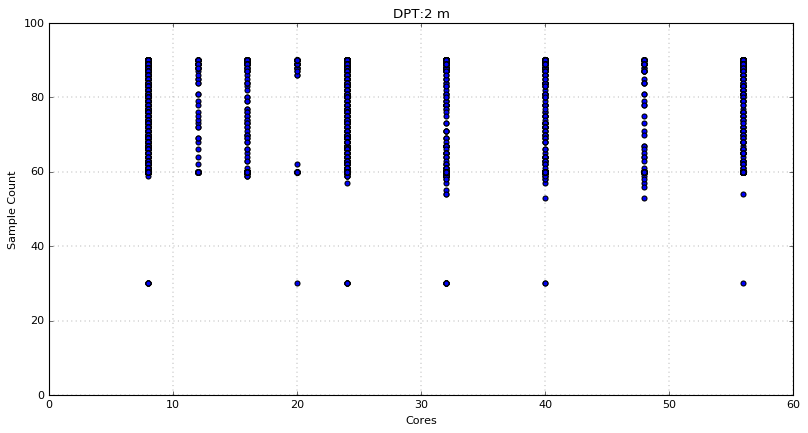

In [15]:
plt.scatter(cores, count)
plt.xlabel('Cores')
plt.ylabel('Sample Count')
plt.title(var)
plt.grid()
plt.ylim(ymin=0)